In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv')

In [ ]:
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [ ]:
# Checking the size of data in train.csv
df.shape

(9516837, 45)

In [ ]:
# Checking duplcates in the data

duplicates = df[df.duplicated()]
print(duplicates.shape)

(22559, 45)


In [ ]:
# Drop duplicate columns
df = df.drop_duplicates(keep=False)
print(df.shape)

(9481718, 45)




*   As we can see duplicates has been dropped and now the data size reduced from ***9616837 to 9481718*** rows



In [ ]:
# Identifying the target variable BP, TP and FP
df.IncidentGrade.value_counts()

,count
IncidentGrade,
BenignPositive,4110679
TruePositive,3292574
FalsePositive,2027161


In [ ]:
df.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,...,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06,9.481718e+06
mean,8.435042e+11,1.820838e+02,7.091922e+04,4.068623e+05,1.110310e+02,2.957318e+03,9.567450e+04,1.287087e+05,2.858064e+05,1.502949e+05,...,3.342510e+03,8.807947e+02,2.622306e+05,1.076147e+05,3.583479e+03,4.899241e+00,6.466485e+01,2.238265e+02,1.352466e+03,9.943521e+03
std,4.969024e+11,3.874025e+02,1.209809e+05,4.599053e+05,4.358602e+02,1.148095e+04,1.632181e+04,3.401251e+04,1.411785e+05,3.757154e+04,...,5.112290e+02,1.293471e+01,8.158381e+04,3.220960e+04,9.015676e+01,7.010991e-01,9.283351e+00,6.256336e+01,3.492775e+02,2.593894e+03
min,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.160000e+02,2.295200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.400000e+01,1.052300e+04,2.162160e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.720000e+02,8.483700e+04,6.732450e+05,4.500000e+01,1.810000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [ ]:
#df.info()

In [ ]:
df.shape

(9481718, 45)

In [ ]:
df.isna().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,5453613
IncidentGrade,51304


In [ ]:
df['SuspicionLevel'].value_counts()

,count
SuspicionLevel,
Suspicious,1437822
Incriminated,1515




*   Upon analysis there are more number of missing values for certain columns like **MitreTechniques, IncidentGrade, ActionGrouped, ActionGranular, EmailClusterId, ThreatFamily, ResourceType, Roles, AntispamDirection, SuspicionLevel, LastVerdict** have more null values however removing those columns is not good approach as they are important columns. So it better to impute the null values as separate category **unknown** so we are not missing any important information.





*   **IncidentGrade** is the Target column which contains **Benign Positive, True Positive and False Positive** *italicized text*



In [ ]:
# Handling missing values
missing_columns = ['MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']

In [ ]:
# Replace NaN with 'Unknown' for the selected categorical columns
df.loc[:,missing_columns] = df[missing_columns].fillna('Unknown')

<ipython-input-15-07a6e81292f2>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Unknown' 'Unknown' 'Unknown' ... 'Unknown' 'Unknown' 'Unknown']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,missing_columns] = df[missing_columns].fillna('Unknown')


In [ ]:
#Validating missing values
df.isna().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,0
IncidentGrade,0


In [ ]:
# Validating Id columns by comparing it with 9481718
print(df['Id'].nunique())
print(df['OrgId'].nunique())
print(df['IncidentGrade'].nunique())
print(df['AlertId'].nunique())
print(df['DetectorId'].nunique())

730730
5769
4
1262116
8428


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['day_of_week'] = df['Timestamp'].dt.dayofweek

#dropping timestamp column
df.drop('Timestamp', axis=1, inplace=True)

In [ ]:
df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,day_of_week
0,180388628218,0,612,123247,7,6,InitialAccess,Unknown,TruePositive,Unknown,...,Unknown,5,66,Unknown,Unknown,Unknown,31,6,3,1
1,455266534868,88,326,210035,58,43,Exfiltration,Unknown,FalsePositive,Unknown,...,Unknown,5,66,Unknown,Unknown,Unknown,242,1445,10630,4
2,1056561957389,809,58352,712507,423,298,InitialAccess,T1189,FalsePositive,Unknown,...,Unknown,5,66,Unknown,Suspicious,Suspicious,242,1445,10630,3
3,1279900258736,92,32992,774301,2,2,CommandAndControl,Unknown,BenignPositive,Unknown,...,Unknown,5,66,Unknown,Suspicious,Suspicious,242,1445,10630,0
4,214748368522,148,4359,188041,9,74,Execution,Unknown,TruePositive,Unknown,...,Unknown,5,66,Unknown,Unknown,Unknown,242,1445,10630,5


In [ ]:
# use boxplot for numerical variables

numerical_df = df.select_dtypes(include=[np.number])

numerical_df.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,day_of_week
0,180388628218,0,612,123247,7,6,98799,138268,27,160396,...,881,289573,117668,3586,5,66,31,6,3,1
1,455266534868,88,326,210035,58,43,98799,138268,360606,160396,...,881,289573,117668,3586,5,66,242,1445,10630,4
2,1056561957389,809,58352,712507,423,298,98799,138268,360606,68652,...,881,289573,117668,3586,5,66,242,1445,10630,3
3,1279900258736,92,32992,774301,2,2,98799,138268,360606,13,...,881,289573,117668,3586,5,66,242,1445,10630,0
4,214748368522,148,4359,188041,9,74,98799,138268,360606,160396,...,881,289573,117668,3586,5,66,242,1445,10630,5


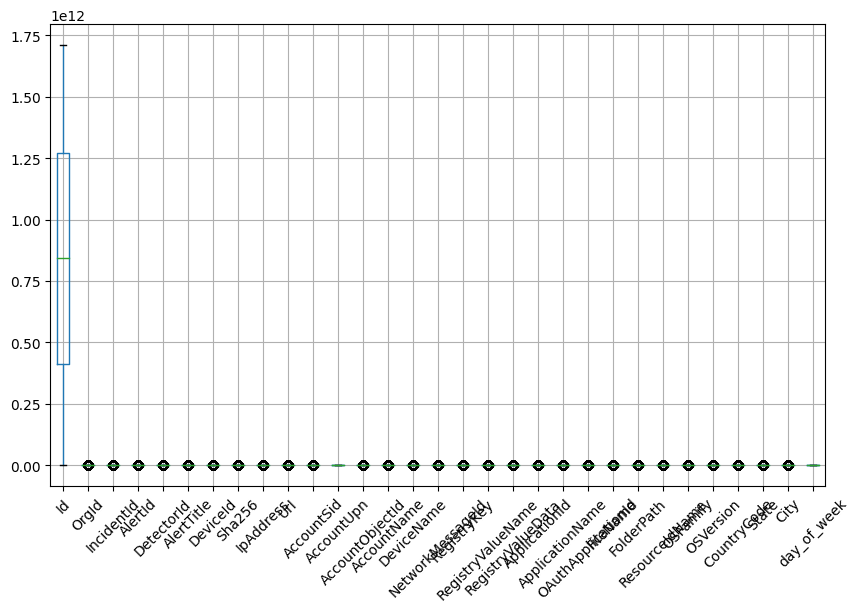

In [ ]:
# Create a boxplot for only numerical columns
numerical_df.boxplot(figsize=(10, 6))

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [ ]:
test = df.head(100)
test.to_csv('test.csv', index=False)

In [ ]:
correlation_matrix = df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Optionally, visualize with a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of 45 Features')
plt.show()

ValueError: could not convert string to float: 'Unknown'

In [ ]:
column_names = df.columns.tolist()
print(column_names[:20])
print(column_names[20:40])
print(column_names[40:60])

['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn']
['AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection']
['SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City']


In [ ]:
#checking columns which has 60% of null values
null_percentage = df.isnull().mean()*100
unwanted_columns = null_percentage[null_percentage > 60].index.tolist()
unwanted_columns

['ActionGrouped',
 'ActionGranular',
 'EmailClusterId',
 'ThreatFamily',
 'ResourceType',
 'Roles',
 'AntispamDirection',
 'SuspicionLevel',
 'LastVerdict']

In [ ]:
# clustering the datas using chunks since it is a large datas

In [ ]:
chunksize = 100000
chunks = []

for chunk in pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv", chunksize=chunksize):
    # Process each chunk (e.g., append to list, filter, transform, etc.)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

<ipython-input-26-6422619e2b7a>:4: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv", chunksize=chunksize):
<ipython-input-26-6422619e2b7a>:4: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv", chunksize=chunksize):
<ipython-input-26-6422619e2b7a>:4: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv", chunksize=chunksize):
<ipython-input-26-6422619e2b7a>:4: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv", chunks

In [ ]:
df.shape

(9516837, 45)

In [ ]:
null_counts = df.iloc[:,:20].isnull().sum()
print(null_counts)

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques    5468386
IncidentGrade        51340
ActionGrouped      9460773
ActionGranular     9460773
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
dtype: int64


In [ ]:
null_counts = df.iloc[:,20:47].isnull().sum()
print(null_counts)

AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath                  0
ResourceIdName              0
ResourceType          9509762
Roles                 9298686
OSFamily                    0
OSVersion                   0
AntispamDirection     9339535
SuspicionLevel        8072708
LastVerdict           7282572
CountryCode                 0
State                       0
City                        0
dtype: int64


In [ ]:
print(df.iloc[:,:20].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 20 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Id               int64 
 1   OrgId            int64 
 2   IncidentId       int64 
 3   AlertId          int64 
 4   Timestamp        object
 5   DetectorId       int64 
 6   AlertTitle       int64 
 7   Category         object
 8   MitreTechniques  object
 9   IncidentGrade    object
 10  ActionGrouped    object
 11  ActionGranular   object
 12  EntityType       object
 13  EvidenceRole     object
 14  DeviceId         int64 
 15  Sha256           int64 
 16  IpAddress        int64 
 17  Url              int64 
 18  AccountSid       int64 
 19  AccountUpn       int64 
dtypes: int64(12), object(8)
memory usage: 1.4+ GB
None


In [ ]:
print(df.iloc[:,20:45].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 25 columns):
 #   Column              Dtype  
---  ------              -----  
 0   AccountObjectId     int64  
 1   AccountName         int64  
 2   DeviceName          int64  
 3   NetworkMessageId    int64  
 4   EmailClusterId      float64
 5   RegistryKey         int64  
 6   RegistryValueName   int64  
 7   RegistryValueData   int64  
 8   ApplicationId       int64  
 9   ApplicationName     int64  
 10  OAuthApplicationId  int64  
 11  ThreatFamily        object 
 12  FileName            int64  
 13  FolderPath          int64  
 14  ResourceIdName      int64  
 15  ResourceType        object 
 16  Roles               object 
 17  OSFamily            int64  
 18  OSVersion           int64  
 19  AntispamDirection   object 
 20  SuspicionLevel      object 
 21  LastVerdict         object 
 22  CountryCode         int64  
 23  State               int64  
 24  City                int6

In [ ]:
#checking tp, bp, fp before imputation
print(df['IncidentGrade'].value_counts())

IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64


In [ ]:
#checking columns which has 60% of null values
null_percentage = df.isnull().mean()*100
unwanted_columns = null_percentage[null_percentage > 60].index.tolist()

In [ ]:
print(unwanted_columns)

['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [ ]:
#dropping 80% of null values holding columns which will make noise to the model prediction after imputing
df = df.drop(columns=['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'])
print(df.iloc[:,:20].isnull().sum())


Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques    5468386
IncidentGrade        51340
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
dtype: int64


In [ ]:
print(df.iloc[:,:20].isnull().sum())

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques    5468386
IncidentGrade        51340
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
dtype: int64


In [ ]:
print(df.iloc[:,20:45].isnull().sum())

DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64


In [ ]:
print(df['IncidentGrade'].unique())
print(df['MitreTechniques'].unique())

['TruePositive' 'FalsePositive' 'BenignPositive' nan]
[nan 'T1189' 'T1078;T1078.004' ...
 'T1055;T1055.002;T1055.004;T1055.012;T1071;T1106' 'T1566;T0865;T1650'
 'T1078;T1078.001']


In [ ]:
# Columns to use for predicting IncidentGrade
categorical_columns = ['IncidentGrade', 'Category', 'EntityType', 'AlertTitle',
                       'DeviceId', 'OSFamily', 'ApplicationId',
                       'ApplicationName', 'IpAddress', 'CountryCode',
                       'State', 'City']

In [ ]:
# Step 1: Separate rows with and without missing IncidentGrade
df_known_grade = df[df['IncidentGrade'].notna()]  # Rows where IncidentGrade is known
df_missing_grade = df[df['IncidentGrade'].isna()]  # Rows where IncidentGrade is missing

In [ ]:
# Encode categorical columns to numeric
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure all data is string for encoding


In [ ]:
# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Prepare the columns for KNN imputation
columns_for_knn = ['Category', 'IncidentGrade', 'EntityType', 'AlertTitle',
                   'DeviceId', 'OSFamily', 'ApplicationId',
                   'ApplicationName', 'IpAddress', 'CountryCode',
                   'State', 'City']

In [ ]:
# Apply the KNN imputer
df[columns_for_knn] = knn_imputer.fit_transform(df[columns_for_knn])


In [ ]:
print(df['IncidentGrade'].isna().sum())

0


In [ ]:
# Check data types again after encoding
print(df[columns_for_knn].dtypes)

Category           float64
IncidentGrade      float64
EntityType         float64
AlertTitle         float64
DeviceId           float64
OSFamily           float64
ApplicationId      float64
ApplicationName    float64
IpAddress          float64
CountryCode        float64
State              float64
City               float64
dtype: object


In [ ]:
### encoding for mitretechniques

In [ ]:
# First, handle the encoding for categorical variables
categorical_columns = ['Category', 'EntityType', 'AlertTitle', 'DeviceId',
                       'OSFamily', 'ApplicationId', 'ApplicationName',
                       'IpAddress', 'CountryCode', 'State', 'City']

# Encode categorical columns to numeric
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure all data is string for encoding

In [ ]:
# Now, select the columns for KNN imputation
columns_for_knn = ['Category', 'EntityType', 'AlertTitle',
                   'DeviceId', 'OSFamily', 'ApplicationId',
                   'ApplicationName', 'IpAddress', 'CountryCode',
                   'State', 'City']

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

In [ ]:
for col in categorical_columns:
    print(f"{col} unique values: {df[col].unique()}")

Category unique values: [10  7  1  6 16  9  0  2 13  5 12  4  8 14 11 15 17  3 19 18]
EntityType unique values: [15 32 31 21 27 19  5  2 11 22  6 20 24  7 26 29 30 28 12  0  4  3 23 14
  1 25  8 13 16  9 17 18 10]
AlertTitle unique values: [54150 39334 27442 ...  9396 10038  8558]
DeviceId unique values: [75704 15231  7925 ... 62545 54647 49007]
OSFamily unique values: [5 0 2 1 3 4]
ApplicationId unique values: [ 998 1078 1186 ...  709  472 1627]
ApplicationName unique values: [1985 1654 2048 ... 1044 1678  942]
IpAddress unique values: [150722 218279 176524 ... 214923 136933 102770]
CountryCode unique values: [161 153 214 203 169  24 163 112 172 159   0   1 170  79 142 178 173 191
 177 122  68 181 225 164 192  13 195 189  46 167  35 158  57 162 155 101
 154 183 182 193 200 150 198 168 174 113 209 156  47  90 190   2 165 197
 171 204 160 166 187 176 196 184 175 133 157 194 201 224 179 212 208 218
 226 210 188 180 199 215 233  16  12   6 186 211 202 232  60 206 205 223
 207  22 110   4 

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer only on numeric columns
df[columns_for_knn] = knn_imputer.fit_transform(df[columns_for_knn])

# If MitreTechniques still has NaN values, you might want to handle them separately
df['MitreTechniques'] = df['MitreTechniques'].fillna(df['MitreTechniques'].mode()[0])  # Simple mode imputation for safety


In [ ]:
print(df['MitreTechniques'].isna().sum())

0


In [ ]:
# Check data types again after encoding
print(df[columns_for_knn].dtypes)

Category           float64
EntityType         float64
AlertTitle         float64
DeviceId           float64
OSFamily           float64
ApplicationId      float64
ApplicationName    float64
IpAddress          float64
CountryCode        float64
State              float64
City               float64
dtype: object


In [ ]:
df.isnull().sum()

,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,0
IncidentGrade,0


In [ ]:
df.value_counts()

Id             OrgId  IncidentId  AlertId  Timestamp                 DetectorId  AlertTitle  Category  MitreTechniques  IncidentGrade  EntityType  EvidenceRole  DeviceId  Sha256  IpAddress  Url     AccountSid  AccountUpn  AccountObjectId  AccountName  DeviceName  NetworkMessageId  RegistryKey  RegistryValueName  RegistryValueData  ApplicationId  ApplicationName  OAuthApplicationId  FileName  FolderPath  ResourceIdName  OSFamily  OSVersion  CountryCode  State  City    MitreTechniques_encoded
1597727837199  55     54825       33451    2024-05-25T15:31:30.000Z  486         42110.0     8.0       T1078;T1078.004  0.0            13.0        Related       73007.0   138268  131424.0   160396  441377      673934      425863           453297       153085      529644            1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  1193                       8
1374389535242  77     69095       45104    2024-06-11T19:05:30.000Z  1           1.0         2.0       T1566.002        0.0            13.0        Related       73007.0   138268  131424.0   160396  441377      673934      425863           453297       153085      529644            1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  1108                       7
412316860996   43     8736        28368    2024-06-16T19:58:07.000Z  1           1.0         2.0       T1566.002        0.0            13.0        Related       73007.0   138268  131424.0   160396  441377      673934      425863           453297       153085      529644            1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  1108                       7
17179870027    107    68575       116695   2024-06-16T21:25:57.000Z  13          75791.0     2.0       T1566            2.0            14.0        Related       73007.0   138268  131424.0   160396  441377      8192        425863           453297       153085      51884             1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  1105                       6
1099511630153  1182   4148        138242   2024-06-04T16:44:39.000Z  47          19593.0     2.0       T1566.002        2.0            13.0        Related       73007.0   138268  131424.0   160396  441377      673934      425863           453297       153085      529644            1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  1108                       6
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ..
558345749592   1139   185292      1024336  2024-06-12T20:28:58.000Z  0           0.0         2.0       T1078;T1078.004  1.0            30.0        Related       73007.0   138268  131424.0   160396  441377      673934      425863           453297       153085      529644            1631         635                860                1726.0         1096.0           881                 289573    117668      3586            5.0       66         61.0         728.0  4602.0  705                       

In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 546298


In [ ]:
df.drop(duplicates)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,MitreTechniques_encoded
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,49059.0,2.0,T1078;T1078.004,2.0,...,881,289573,117668,3586,5.0,66,70.0,1288.0,1843.0,1193
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,32596.0,17.0,T1078;T1078.004,1.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,19383.0,2.0,T1189,1.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,864
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,9418.0,1.0,T1078;T1078.004,0.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,62012.0,16.0,T1078;T1078.004,2.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1056561956622,0,90,496631,2024-06-08T15:26:08.000Z,7,49059.0,2.0,T1078;T1078.004,2.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
9516833,1228360650033,59,196410,748366,2024-06-06T09:40:08.000Z,2,9418.0,1.0,T1078;T1078.004,0.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
9516834,867583395122,44,14117,7425,2024-06-11T22:51:03.000Z,78,46256.0,17.0,T1078;T1078.004,0.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
9516835,395136991850,43,644,8973,2024-05-20T23:01:01.000Z,52,11112.0,19.0,T1078;T1078.004,0.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193


In [ ]:
df.shape

(9516837, 37)

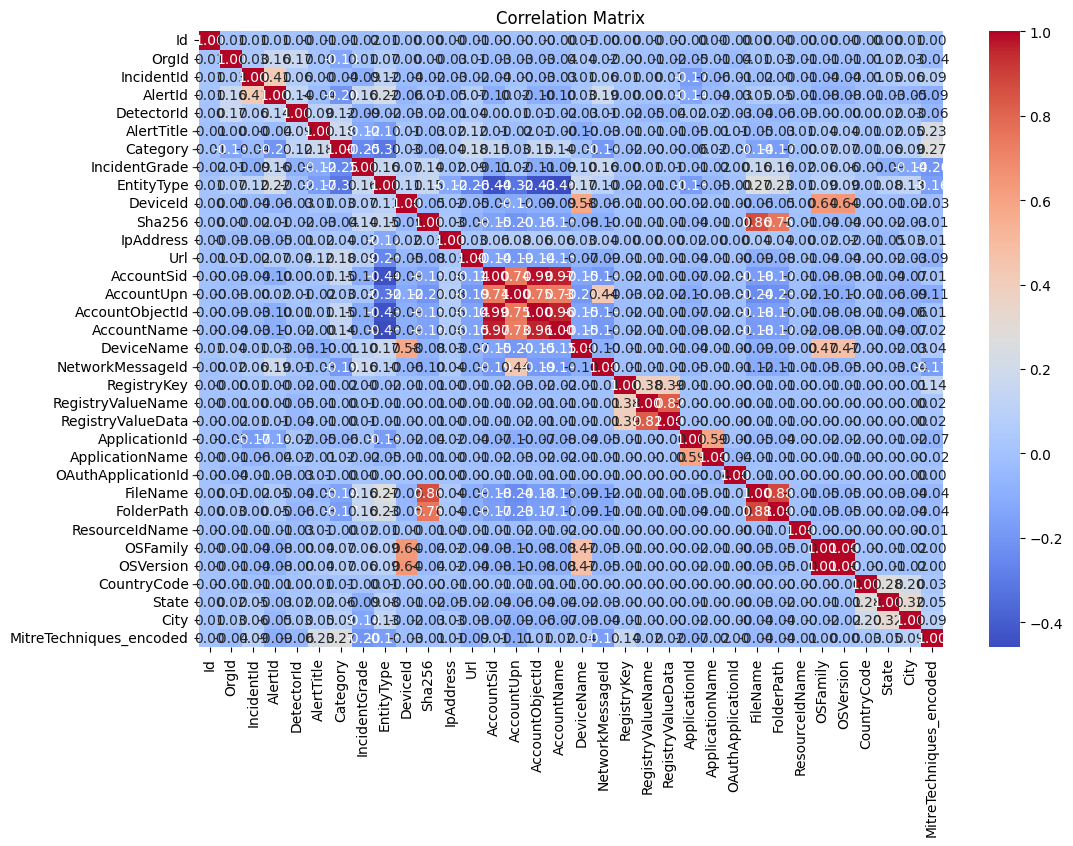

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:

# Define the output file path
output_file_path = '/content/drive/MyDrive/Colab Notebooks/train_data/preprocessed_GUIDE_Train.csv'

# Save the preprocessed DataFrame to a new CSV file
df.to_csv(output_file_path, index=False)  # Use index=False to avoid saving the index as a column


In [ ]:
# Load the saved CSV to verify
saved_df = pd.read_csv(output_file_path)

# Display the first few rows to verify
print(saved_df.head())


              Id  OrgId  IncidentId  AlertId                 Timestamp  \
0   180388628218      0         612   123247  2024-06-04T06:05:15.000Z   
1   455266534868     88         326   210035  2024-06-14T03:01:25.000Z   
2  1056561957389    809       58352   712507  2024-06-13T04:52:55.000Z   
3  1279900258736     92       32992   774301  2024-06-10T16:39:36.000Z   
4   214748368522    148        4359   188041  2024-06-15T01:08:07.000Z   

   DetectorId  AlertTitle  Category  MitreTechniques  IncidentGrade  ...  \
0           7     49059.0       2.0  T1078;T1078.004            2.0  ...   
1          58     32596.0      17.0  T1078;T1078.004            1.0  ...   
2         423     19383.0       2.0            T1189            1.0  ...   
3           2      9418.0       1.0  T1078;T1078.004            0.0  ...   
4           9     62012.0      16.0  T1078;T1078.004            2.0  ...   

   OAuthApplicationId FileName  FolderPath  ResourceIdName  OSFamily  \
0                 881   28

In [ ]:
saved_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 37 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Id                       int64  
 1   OrgId                    int64  
 2   IncidentId               int64  
 3   AlertId                  int64  
 4   Timestamp                object 
 5   DetectorId               int64  
 6   AlertTitle               float64
 7   Category                 float64
 8   MitreTechniques          object 
 9   IncidentGrade            float64
 10  EntityType               float64
 11  EvidenceRole             object 
 12  DeviceId                 float64
 13  Sha256                   int64  
 14  IpAddress                float64
 15  Url                      int64  
 16  AccountSid               int64  
 17  AccountUpn               int64  
 18  AccountObjectId          int64  
 19  AccountName              int64  
 20  DeviceName               int64  
 21  NetworkM

In [ ]:
p_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/preprocessed_GUIDE_Train.csv")
p_train.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,MitreTechniques_encoded
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,49059.0,2.0,T1078;T1078.004,2.0,...,881,289573,117668,3586,5.0,66,70.0,1288.0,1843.0,1193
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,32596.0,17.0,T1078;T1078.004,1.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,19383.0,2.0,T1189,1.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,864
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,9418.0,1.0,T1078;T1078.004,0.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,62012.0,16.0,T1078;T1078.004,2.0,...,881,289573,117668,3586,5.0,66,61.0,728.0,4602.0,1193


In [ ]:
#test dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Test.csv")

<ipython-input-3-922e432b35c1>:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Test.csv")


In [ ]:
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [ ]:
df.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,...,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06
mean,8.462250e+11,1.756698e+02,6.780345e+04,4.072191e+05,1.008391e+02,2.529514e+03,9.575061e+04,1.283939e+05,2.873898e+05,1.504279e+05,...,3.342993e+03,8.808119e+02,2.618998e+05,1.074020e+05,3.583541e+03,4.899529e+00,6.466873e+01,2.222218e+02,1.344570e+03,9.883839e+03
std,4.923351e+11,3.708729e+02,1.178736e+05,4.550578e+05,4.082934e+02,1.044138e+04,1.615628e+04,3.457595e+04,1.400920e+05,3.734754e+04,...,5.096996e+02,1.238317e+01,8.208434e+04,3.260346e+04,9.012124e+01,7.001299e-01,9.269678e+00,6.499822e+01,3.626851e+02,2.696302e+03
min,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,8.000000e+00,4.110000e+02,2.365900e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.300000e+01,8.818000e+03,2.228970e+05,7.000000e+00,9.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.730000e+02,7.944000e+04,6.711010e+05,3.900000e+01,1.160000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.138000e+03,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [ ]:
null_values=df.isnull().sum()
print(null_values)

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [ ]:
#checking columns which has 60% of null values
null_percentage = df.isnull().mean()*100
unwanted_columns = null_percentage[null_percentage > 60].index.tolist()

In [ ]:
print(unwanted_columns)

['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [ ]:
df.drop(unwanted_columns, axis = 1, inplace = True)

In [ ]:
print(unwanted_columns)

['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [ ]:
# Final preprocessing (train dataset)

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_data/GUIDE_Train.csv')


In [ ]:
#Drop columns with more than 60% missing values
null_percentage = df.isnull().mean() * 100
unwanted_columns = null_percentage[null_percentage > 60].index.tolist()
df = df.drop(columns=unwanted_columns)


In [ ]:
# Separate the categorical columns (including IncidentGrade for KNN imputation)
categorical_columns = ['IncidentGrade', 'Category', 'EntityType', 'AlertTitle',
                       'DeviceId', 'OSFamily', 'ApplicationId',
                       'ApplicationName', 'IpAddress', 'CountryCode',
                       'State', 'City']


In [ ]:
#Handle missing values for IncidentGrade using KNN imputation
# Separate rows with and without IncidentGrade for imputation
df_known_grade = df[df['IncidentGrade'].notna()]  # Rows where IncidentGrade is known
df_missing_grade = df[df['IncidentGrade'].isna()]  # Rows where IncidentGrade is missing

In [ ]:
# encode incidentgrade which has known values
label_encoder = LabelEncoder()
df_known_grade['IncidentGrade_encoded'] = label_encoder.fit_transform(df_known_grade['IncidentGrade'])


<ipython-input-8-379c8974ce38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known_grade['IncidentGrade_encoded'] = label_encoder.fit_transform(df_known_grade['IncidentGrade'])


In [ ]:
#Combine df_known_grade and df_missing_grade (for KNN imputation)
df_combined = pd.concat([df_known_grade, df_missing_grade])

In [ ]:
#Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=1)

In [ ]:
 #Apply KNN imputation (only imputing 'IncidentGrade_encoded')
df_combined['IncidentGrade_encoded'] = knn_imputer.fit_transform(df_combined[['IncidentGrade_encoded' n]])


KeyboardInterrupt: 

In [ ]:
#Decode the imputed numeric values back to original labels
df_combined['IncidentGrade'] = label_encoder.inverse_transform(df_combined['IncidentGrade_encoded'].astype(int))


In [ ]:
#Drop the temporary encoded column if not needed
df_combined = df_combined.drop(columns=['IncidentGrade_encoded'])

In [ ]:
 Check the result
print(df_combined[['IncidentGrade']].isnull().sum())